<img src="https://pbs.twimg.com/profile_images/969600936321736704/WrwKmb8y_400x400.jpg" width="200" height="200" />

# Fitting Growth Response
Rather than model the sensitivities, we can model the growth curve directly. For simplicity, lets assume the the growth factor curve has a gaussian shape, with 3 parameters, a $\mu$ which determines the location of the curve, $\sigma$ which determines the width and $A$ (Normalisation) which determines the height.
$$ A\exp{(-0.5((T-\mu)/\sigma)^2)}$$

The growth curve should be the same for all countries and states. Lets fit this on the US states growing Maize.

In [1]:
import pandas as pd
import pylab as plt
import numpy as np
import seaborn as sns
import pystan

%matplotlib inline

In [2]:
# Read in climate temperatures
clim_precip_maize=pd.read_table('./Crop_data_files/clim_file/temp_climatology_Maize.csv')
clim_precip_maize.rename(columns = {'Unnamed: 0':'Crop_season_location'}, inplace = True)

### Define states to fit over
As we are modelling the growth function with respect to temperature, we need to use the absolute temperature measurements rather than anomalies. Lets add back the climatological mean to the anomalies.

In [94]:
states=['Indiana','Illinois', 'Ohio','Nebraska', 'Iowa','Minnesota']

In [95]:
#Read in and add back mean temperature to get real temperature values
temp_states=[]
for i,s in enumerate(states):
    maize_temp=pd.read_table('./Crop_data_files/maize_met_anoms/Maize_Spring_USA_'+s+'_temp_anom_real.csv')
    maize_temp.rename(columns = {'Unnamed: 0':'Year'}, inplace = True)
    tmp=maize_temp.iloc[:,1:].add(clim_precip_maize[clim_precip_maize['Crop_season_location']== 'Maize_Spring_USA_'+states[0]].iloc[0,1:,])
    temp_states.append(tmp)
temp_states=pd.concat(temp_states,keys=states)

In [96]:
temp_states

Jan        Feb       Mar      Apr      May      Jun  \
Indiana   0     -1.9534   -3.97301   2.59058  10.0881  17.3264  20.9624   
          1    -4.00883   0.874847   4.86918  13.9457  15.2778  22.6881   
          2    -6.41284   -2.59879    4.7838  8.75127  19.9566  19.5645   
          3   -0.465296    1.96229    6.1551  9.13795  15.1196  22.1406   
          4    -5.10546    3.22889  0.673888  10.3269  15.3663   23.748   
          5    -5.70493   -2.89812   7.23863  14.3429  18.4319  20.7701   
          6   -0.912048  -0.499908   6.81455  13.4268  17.8881  22.5552   
          7    -1.76537    1.84541   7.20209  11.7326  20.2266  23.5955   
          8    -3.01212   -1.95634    5.6462  11.3608  18.0358  23.2077   
          9     2.67857   -2.49459   6.04169  10.5955  15.5242  21.7484   
          10    3.44255    3.09323   7.68794  11.0972  15.7078  22.1507   
          11   -2.28052    2.21587   7.22717  13.4812  20.8521  23.6615   
          12   -0.16997    3.40981   5.74444  11.0505  16.1849  19.7391   
          13 -0.0173301   -2.03527   3.39191  10.4553  17.5315  21.5171   
          14   -5.85973   -1.65559   4.84746  12.7552  15.6909  23.4092   
          15   -1.37723  -0.592061   6.55102  11.1221  16.6471  22.5709   
          16   -2.70339  -0.100481   2.02085  10.0078  16.7241  22.2153   
          17   -3.63169    1.65543    5.8699  8.89772  13.6574  20.9806   
          18    2.05681     4.4293   5.56694  11.4184  19.4995  21.8538   
          19    -2.0289    2.81877   2.99723  12.1992  17.8924  22.6487   
          20   -2.26375    3.58884   8.04499  10.7229  18.4269   21.601   
          21   -2.02941    1.16934   3.36088   14.056   17.822  21.0009   
          22    2.27671    2.44643   4.32397  12.4996  15.0693  22.9426   
          23   -5.02928   -2.90573   6.12223  11.9321  15.7047  19.9331   
          24   -3.58426  0.0155546   7.17004  12.4253  19.1386  21.2121   
          25   -1.42508    1.99761   3.30135  12.6427  15.3971  23.8479   
          26    4.19659   0.528402   5.20404  13.5371  16.4012  21.2803   
          27   0.254286   -5.87735   8.93536  10.4911   19.447  22.9623   
          28   -1.34529   -1.50774   4.07293  12.0195  15.6034  22.6876   
          29   -5.16117   0.970609   7.58417  11.6994  17.0706  22.4303   
...                 ...        ...       ...      ...      ...      ...   
Minnesota 5    -4.13192   -2.09789   7.74112  14.6075  19.3596  20.1646   
          6   -0.568592   -2.66535   6.98464  13.3611  17.6148  23.0568   
          7     1.73212    6.88246   8.64409  15.2516  20.1553  23.9406   
          8    -5.01356   -3.92133   6.57787  11.9771  20.6204  25.6252   
          9     1.99412   -5.44154   2.61215  11.0271   16.805  21.4253   
          10    4.45338    1.93223   7.63872  11.9294  15.6109  22.5983   
          11   -3.92862    3.11584   6.90338  13.1766  18.9713  24.2099   
          12    2.02583    4.47921   6.46294  9.77775  18.1172  20.4962   
          13   -3.43702   -2.46786   2.72279  9.73175  16.2897  19.9857   
          14   -8.40981   -5.12762   6.79489  11.7895  18.4134  23.1323   
          15   -1.03702  0.0433769   6.19355  8.84094  15.7857  23.2486   
          16   -5.47606  -0.955331   1.75054  9.21849  15.3219  22.4267   
          17   -4.81259  -0.626674   3.82706  8.84177   14.111  22.5276   
          18 -0.0648863    6.23277   4.26645  12.6663  19.7089  20.2156   
          19   -3.52869    4.28585   6.01729  12.0433  17.6562  21.7146   
          20    -1.5933    4.23661   9.78457  11.5349  18.2122  20.5942   
          21   0.115828   -4.55684   2.19694  12.6839  17.6015  22.0952   
          22    2.96631    4.46447    1.3322  11.4276  15.0573  23.5834   
          23   -1.99306   -1.99945   5.05857  11.9879  16.0229  21.3427   
          24   -3.78915  0.0625075     7.669  12.9472  16.5216  20.3546   
          25   -2.39663    3.38214   5.23942  14.1619  15.9437  24.1862   
          26    5.67315  0.0749459    5.7632 

Lets read in our Stan model and compile

In [97]:
# Compile model
sm=pystan.StanModel(file='BMSM-GaussGR.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_d04a20d59a41a46fcc332e2654a5244e NOW.


As a first attempt, lets use the yield anomalies data and add back a constant 6. We will deal with fitting the Yield trend due to efficiency later.

In [98]:
# Read in Yields
yields=pd.read_table('./Crop_data_files/Maize_median_yield_anoms.csv')

In [99]:
yields

,Unnamed: 0,Region,1960,1961,1962,1963,1964,1965,1966,1967,...,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014
0,0,Maize_Spring_USA_Nebraska,-0.06276,-0.15690,0.40794,0.00000,-0.40794,0.00000,0.37656,0.00000,...,0.00000,-0.50208,0.00000,0.00000,1.00416,0.18828,-0.37656,-1.506240,0.28242,0.62760
1,1,Maize_Spring_USA_Iowa,-0.75312,-0.04707,0.00000,0.15690,-0.15690,0.00000,0.03138,-0.03138,...,0.12552,-0.31380,0.00000,0.00000,0.62760,-0.37656,0.43932,-1.757280,-0.25104,0.87864
2,2,Maize_Spring_USA_Illinois,-0.69036,-0.18828,0.31380,0.12552,-0.31380,0.43932,-0.50208,0.62760,...,-1.31796,-0.75312,0.06276,0.31380,0.00000,0.00000,0.00000,-3.263520,0.65898,1.38072
3,3,Maize_Spring_USA_Indiana,-0.37656,-0.25104,0.50208,0.31380,-0.62760,0.50208,-0.37656,-0.12552,...,0.00000,0.00000,-0.18828,0.18828,0.87864,0.00000,-0.69036,-3.640080,0.97278,0.69036
4,4,Maize_Spring_USA_Minnesota,-0.34518,0.15690,0.00000,0.50208,-0.18828,-0.50208,0.25104,-0.25104,...,0.94140,0.00000,-1.00416,0.00000,0.75312,0.75312,-0.62760,0.376560,0.09414,-0.18828
5,5,Maize_Spring_USA_Ohio,-0.37656,-0.06276,0.12552,0.25104,-0.69036,-0.25104,0.31380,-0.31380,...,-0.81588,0.56484,0.00000,-1.75728,1.12968,0.43932,-0.43932,-2.510400,0.65898,0.12552
6,6,Maize_Spring_China_Jilin,-0.23500,0.11935,-0.03450,-0.04300,0.05020,-0.05020,0.00000,0.13240,...,0.18101,0.58294,-0.18101,0.54988,-0.45689,-0.54988,0.00000,0.194480,0.08097,NaN
7,7,Maize_Spring_China_Liaoning,-0.49600,-0.05390,0.00000,0.00000,0.00000,0.00000,0.00000,0.17770,...,0.01228,-0.19889,-0.26599,0.46488,-0.93963,-0.81114,0.00000,0.039145,0.51029,NaN
8,8,Maize_Spring_China_Heilongjiang,1.41700,-0.28565,0.00000,0.07270,-0.09070,-0.00440,0.00000,0.35160,...,0.38670,0.00000,-0.98415,0.28129,-0.28129,0.00000,0.26910,-0.134550,0.07151,NaN
9,9,Maize_Summer_China_Hebei,-0.10190,0.05095,0.01090,-0.17080,0.00000,0.00000,0.15120,0.07440,...,0.00000,0.00000,0.00079,0.10930,-0.04865,-0.06144,0.00000,0.004350,0.07125,NaN


In [102]:
n_years=np.array(yields[yields['Region']=='Maize_Spring_USA_Indiana'].iloc[0,22:]).size
data={
    'n_regions':len(states),
    'n_years':n_years,
    'd_temp':np.array(temp_states.iloc[:,3:9]).reshape(len(states),np.int(np.array(temp_states.iloc[:,3:9]).shape[0]/len(states)),6).astype(float),
    'd_yields':np.array(yields[yields["Region"].isin(['Maize_Spring_USA_'+s for s in states])].iloc[:,22:]).astype(float)+6,
    'n_gf':40,
    'temp':np.arange(0,40,1)

}

Lets fit the model and look at summary statistics

In [103]:
fit=sm.sampling(data=data,chains=4,iter=1000,verbose=True,seed=1308)

In [104]:
fit

Inference for Stan model: anon_model_d04a20d59a41a46fcc332e2654a5244e.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

                    mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu                 19.28    0.02   0.63  17.87  18.89  19.32  19.71  20.38    768    1.0
sigma               4.81    0.02   0.42   4.08   4.51   4.77   5.08    5.7    675    1.0
norm                1.37  1.8e-3   0.05   1.27   1.33   1.37    1.4   1.47    852    1.0
fdy[0]            1.3e-3  1.5e-4 3.4e-3 8.7e-6 1.1e-4 3.9e-4 1.2e-3 8.1e-3    499   1.01
fdy[1]            2.4e-3  2.4e-4 5.4e-3 2.8e-5 3.0e-4 8.9e-4 2.5e-3   0.01    511   1.01
fdy[2]            4.4e-3  3.6e-4 8.2e-3 8.3e-5 7.2e-4 1.9e-3 5.0e-3   0.02    525   1.01
fdy[3]            7.8e-3  5.3e-4   0.01 2.4e-4 1.6e-3 4.1e-3 9.4e-3   0.04    542    1.0
fdy[4]              0.01  7.7e-4   0.02 6.5e-4 3.6e-3 8.1e-3   0.02   0.06    559    1.0
fdy[5]      

We now use some more sophisticated diagnostics to check the inference is behaving properly

In [105]:
# carry out some diagnostic checks on fit
from xidplus.stan_fit import stan_utility
stan_utility.check_div(fit)
stan_utility.check_energy(fit)
stan_utility.check_treedepth(fit)

0.0 of 2000 iterations ended with a divergence (0.0%)
0 of 2000 iterations saturated the maximum tree depth of 10 (0.0%)


In [106]:
samples=fit.extract()

## Examine posterior samples
Now lets take a detailed look at the posterior samples from the fit. We will examine:
1. The posterior distribution on the growth curve parameters
2. The posterior distribution on the growth curve
3. Posterior predicitive checks (i.e. comparing predicited yield to real world yield)

Text(0.5,1,'Growth Curve')

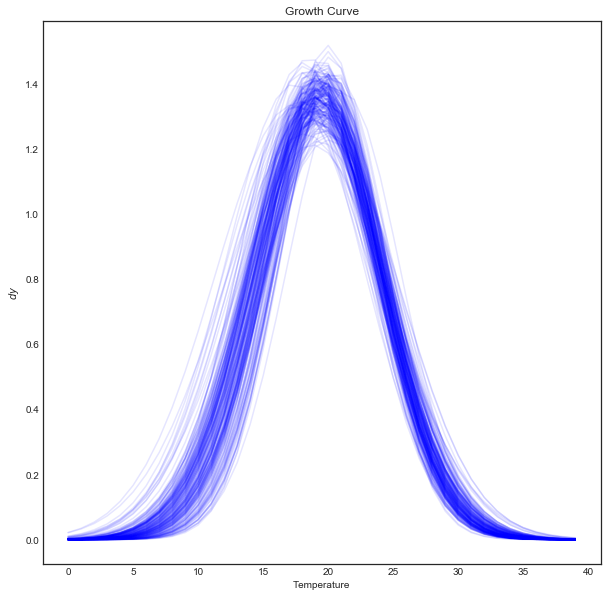

In [107]:
plt.figure(figsize=(10,10))
for i in range(0,2000,10):
    plt.plot(fit.data['temp'],samples['fdy'][i,:],alpha=0.1, c='b')
plt.xlabel('Temperature')
plt.ylabel(r'$dy$')
plt.title('Growth Curve')

The figure above shows growth curve samples from the posterior. Each curve is a possible growth curve. Where the lines overlap most represents the curve is known more precisely at these points, compared to where the lines are more spaced indicating there is more uncertianty. Our results indicate that the high temperature tail to the growth curve is known to a good degree of precison where as the the low temperature tail is more uncertian.

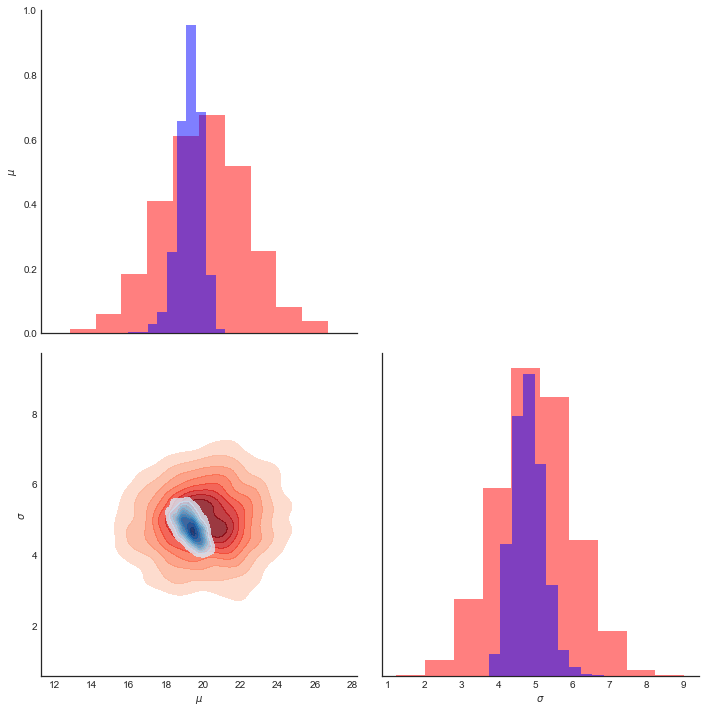

In [108]:
df=pd.DataFrame(np.random.multivariate_normal(np.array([20,5]),np.array([[5.0,0.0],[0.0,1.0]]),2000),columns=['$\mu$','$\sigma$'])
g=sns.PairGrid(data=df,size=5,diag_sharey=False)
g.map_diag(plt.hist,color='Red',alpha=0.5)
g.map_lower(sns.kdeplot, cmap="Reds",alpha=0.8,n_levels=10,normed=True, shade=True,shade_lowest=False)
df=pd.DataFrame(np.vstack((samples['mu'],samples['sigma'])).T,columns=['$\mu$','$\sigma$'])
g.data=df
g.map_diag(plt.hist,color='Blue',alpha=0.5)
g.map_lower(sns.kdeplot, cmap="Blues",alpha=0.8,n_levels=10,normed=True, shade=True,shade_lowest=False)

g.axes[0,1].set_axis_off()


The figure above shows the prior (red) and posterior (blue) distribution for our parameters of the growth function. The bottom left plot shows the 2D distribution of $\mu$ and $\sigma$, and plotted alongside are the two 1D marginalised probability distributions. It is clear that the infered posterior probability distribution has significantly shrunk compared to prior, indicating the fit is being driven by the data.

## Posterior Predictive Checks
Lets now do a couple of posterior predicitive checks. Lets first visualise the predicited yield distributions coming from the model with a violin plot and plot the real yield data on top.

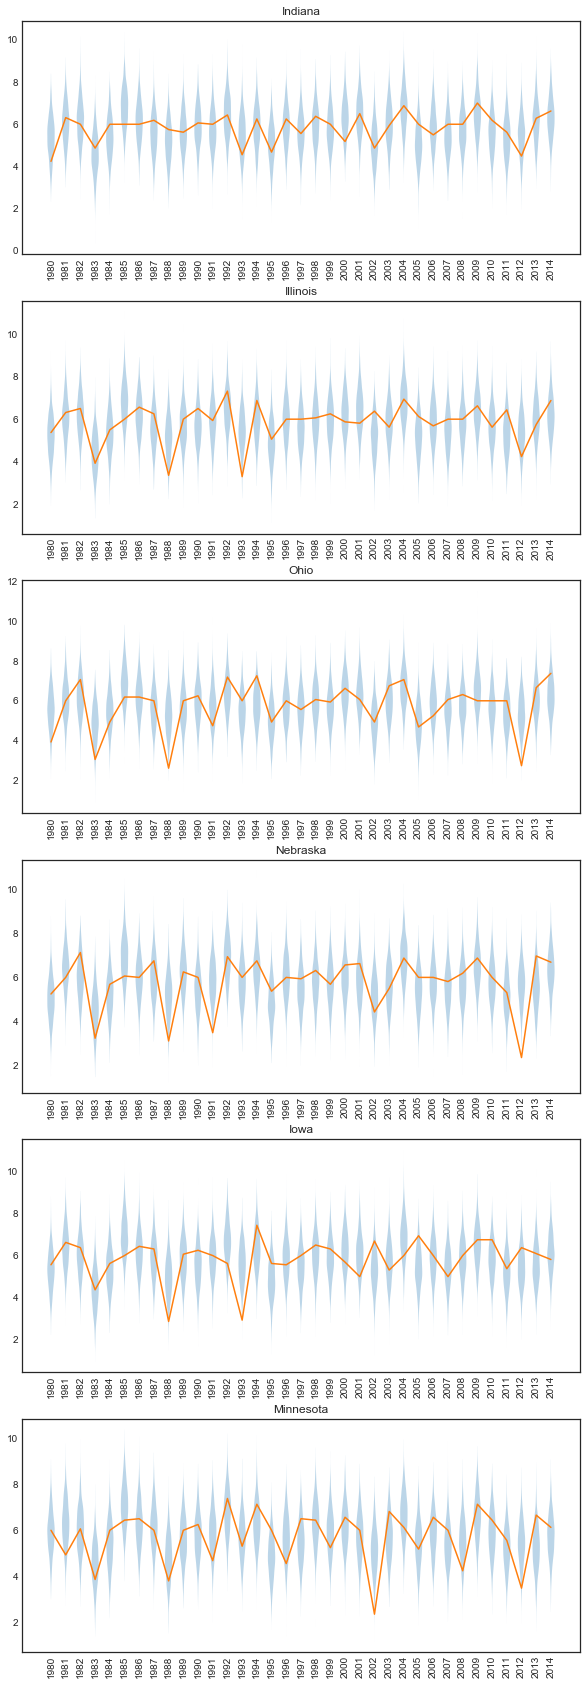

In [116]:
plt.figure(figsize=(10,5*len(states)))
for s in range(0,len(states)):
    plt.subplot(len(states),1,s+1)
    plt.violinplot(samples['pred_yields'][:,s,:],showextrema=False);
    plt.xticks(range(1,36),np.arange(1980,2015),rotation=90);
    plt.plot(range(1,36),fit.data['d_yields'][s,:])
    plt.title(states[s])

Most points lie in the distribution, indiciating a reasonable fit. Lets now quantify

### Posterior Predictive checking and Bayesian P-value maps

When examining goodness of fits, the typical method is to look at the residuals. i.e. $\frac{data - model}{\sigma}$. Because we have distribution of $y^{rep}$, we can do this in a more probabilisitic way using posterior predictive checks. For more information on posterior predictive checks, [Gelman et al. 1996](http://www.stat.columbia.edu/~gelman/research/published/A6n41.pdf) is a good starting point.

For our case, the best way to carry out posterior predictive checks is to think about the yield in one year. We can look at where the real yield value is in relation to the distribution from $y^{rep}$. 

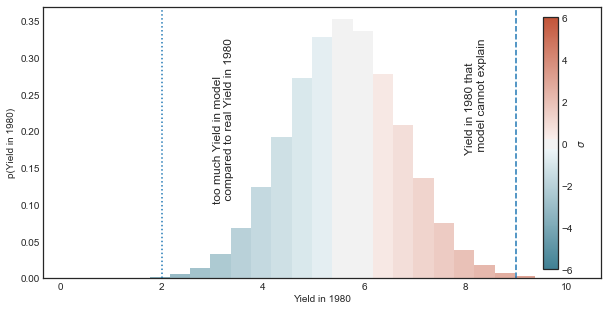

In [110]:
import matplotlib as mpl
sns.set_style("white")

fig=plt.figure(figsize=(10,5))


# This is  the colormap I'd like to use.
cm = sns.diverging_palette(220, 20, as_cmap=True)

# Get the histogramp
Y,X = np.histogram(samples['pred_yields'][:,0,:], 25, normed=1)
#C = [cm(((x-X.min())/x_span)) for x in X]
C = [cm(((((x-np.mean(samples['pred_yields'][:,0,:]))/np.std(samples['pred_yields'][:,0,:]))+6)/12.0)) for x in X]


plt.bar(X[:-1],Y,color=C,width=X[1]-X[0])
plt.xlabel('Yield in 1980')
plt.ylabel('p(Yield in 1980)')
plt.axvline(9, linestyle='--')
plt.axvline(2,linestyle=':')
plt.annotate('Yield in 1980 that \n model cannot explain',xy=(8, 0.01),  xycoords='data',
            xytext=(8, 0.3), textcoords='data',rotation='vertical',size='large')
plt.annotate('too much Yield in model \n compared to real Yield in 1980',xy=(3, 0.01),  xycoords='data',
            xytext=(3, 0.3), textcoords='data',rotation='vertical',size='large')

#ax1 = fig.add_axes([0.05, 0.80, 0.9, 0.15])
ax1 = fig.add_axes([0.82, 0.15, 0.02, 0.7])

norm = mpl.colors.Normalize(vmin=-6, vmax=6)
cb1 = mpl.colorbar.ColorbarBase(ax1, cmap=cm,
                                norm=norm,
                                orientation='vertical')
cb1.set_label('$\sigma$')

We can calculate fraction of $y^{rep}$ samples above and below real yield value. This is often referred to as the Bayesian p-value and is telling us the probability of drawing the real yield value, from our model which has been inferred on the data. This is tells us if the model is inconsistent with the data, given the uncertianties in parameters and data.

* $\sim 0.5$ means our model is consistent with the data 
* 0.99 or 0.01 means model is missing something.

We can convert this to a typical '$\sigma$' level.

In [111]:
def Bayesian_Pval(yields,pred_yields):
    import scipy.stats as st
    Pvals=np.empty_like(yields)
    n_reg,n_years=yields.shape
    for r in range(0,n_reg):
        for y in range(0,n_years):
            ind=pred_yields[:,r,y]<yields[r,y]
            Pvals[r,y]=st.norm.ppf(ind.sum()/pred_yields[:,r,y].size)
    return Pvals

In [112]:
Pvals=Bayesian_Pval(fit.data['d_yields'],samples['pred_yields'])

Text(0,0.5,'P value')

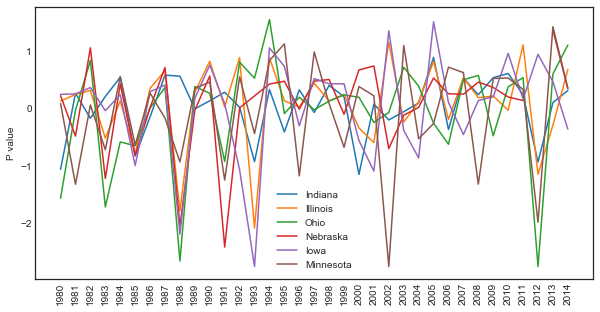

In [117]:
plt.figure(figsize=(10,5))
for s in range(0,len(states)):
    plt.plot(Pvals[s,:],label=states[s])
plt.xticks(range(0,36),np.arange(1980,2015),rotation=90);
plt.legend()
plt.ylabel('P value')

The plot above shows the P values for every state. Most years are between -1 and 1, indicating that the yields are a good fit given the uncertianties in model. The exceptions are 1988,1991, 1993 2002 and 2012 where the yield was dramatically lower than predicited. This would suggest a failure in the model, most likely being the assumption of 

# Fit Yield trend

In [ ]:
np.array(yields[yields["Region"].isin(['Maize_Spring_USA_'+s for s in states])].iloc[:,21:]).astype(float)
plt.plot(np.arange(1960,2015,1),np.array(yields[yields["Region"].isin(['Maize_Spring_USA_'+s for s in states])].iloc[:,1:]).astype(float).T
)